In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from time import time

In [ ]:
# === Загрузка и предобработка данных ===
def load_and_preprocess(path, target_column):
    df = pd.read_csv(path)
    print(f"Dataset shape: {df.shape}")
    print(df.dtypes)
    df = df.dropna()
    for col in df.select_dtypes(include='object').columns:
        df[col] = LabelEncoder().fit_transform(df[col])
    
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    return X, y

In [ ]:
# === Разделение и масштабирование ===
def split_and_scale(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

In [ ]:
# === Обучение моделей ===
def train_models(X_train, X_test, y_train, y_test):
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "SVM": SVC(),
        "RandomForest": RandomForestClassifier(),
        "GradientBoosting": GradientBoostingClassifier(),
        "NaiveBayes": GaussianNB(),
        "KNN": KNeighborsClassifier()
    }

    reports = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        reports[name] = classification_report(y_test, y_pred, output_dict=True)
        print(f"=== {name} ===")
        print(classification_report(y_test, y_pred))
    
    return models, reports

In [ ]:
# === Уменьшение размерности ===
def reduce_and_plot(X, y, method="PCA"):
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "TSNE":
        reducer = TSNE(n_components=2, perplexity=30)
    elif method == "LDA":
        reducer = LDA(n_components=1)
    else:
        raise ValueError("Unsupported method")
    
    X_reduced = reducer.fit_transform(X, y)
    
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, -1], hue=y, palette='Set2')
    plt.title(f"{method} Projection")
    plt.show()

In [ ]:
# === Бутстрэппинг по всем моделям ===
def bootstrap_evaluation(models, X, y, iterations_list=[100, 250]):
    results = {}
    for n_iter in iterations_list:
        print(f"\n--- Bootstrap Evaluation: {n_iter} итераций ---")
        for name, model in models.items():
            scores = []
            for i in range(n_iter):
                X_resample, y_resample = resample(X, y, random_state=i)
                X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                scores.append(accuracy_score(y_test, y_pred))
            mean_acc = np.mean(scores)
            std_acc = np.std(scores)
            print(f"{name:<25} | Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
            results[(name, n_iter)] = (mean_acc, std_acc)
    return results

In [ ]:
# === Гиперпараметры ===
def random_search(model, param_dist, X_train, y_train):
    search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=3, random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    print("Best Params:", search.best_params_)
    return search.best_estimator_


### Pima Indians ###
=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       151
           1       0.62      0.62      0.62        80

    accuracy                           0.74       231
   macro avg       0.71      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231

=== SVM ===
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       151
           1       0.64      0.59      0.61        80

    accuracy                           0.74       231
   macro avg       0.72      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231

=== RandomForest ===
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       151
           1       0.61      0.62      0.62        80

    accuracy                           0.73       231
   macro avg       0.70      0.71      0.71   

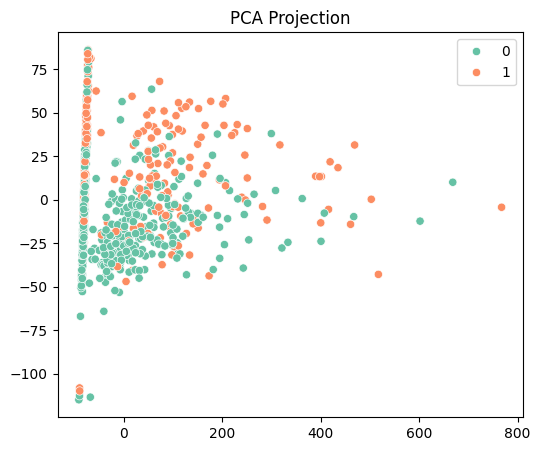

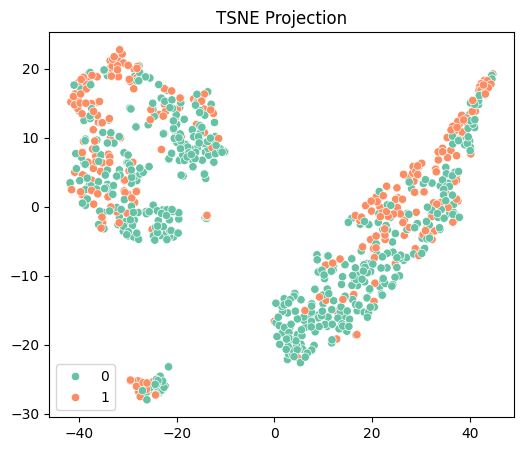

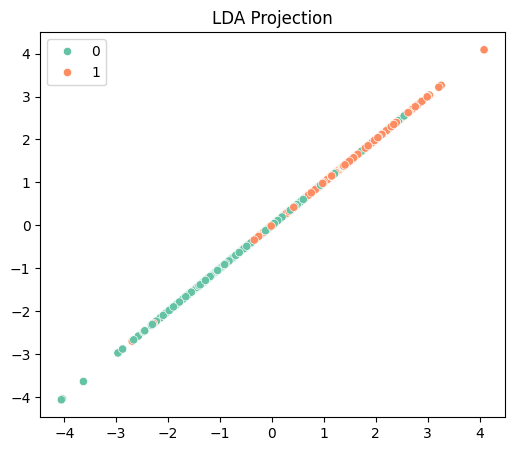

--- Bootstrap Evaluation (100 итераций, Random Forest) ---

--- Bootstrap Evaluation: 100 итераций ---
LogisticRegression        | Accuracy: 0.7718 ± 0.0233
SVM                       | Accuracy: 0.7614 ± 0.0254
RandomForest              | Accuracy: 0.8758 ± 0.0250
GradientBoosting          | Accuracy: 0.8539 ± 0.0243
NaiveBayes                | Accuracy: 0.7584 ± 0.0267
KNN                       | Accuracy: 0.7546 ± 0.0304

--- Bootstrap Evaluation: 250 итераций ---
LogisticRegression        | Accuracy: 0.7715 ± 0.0274
SVM                       | Accuracy: 0.7597 ± 0.0265
RandomForest              | Accuracy: 0.8779 ± 0.0217
GradientBoosting          | Accuracy: 0.8519 ± 0.0229
NaiveBayes                | Accuracy: 0.7575 ± 0.0304
KNN                       | Accuracy: 0.7559 ± 0.0306
--- Hyperparameter Tuning for SVM ---
Best Params: {'kernel': 'linear', 'gamma': 'auto', 'C': 0.1}
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       1

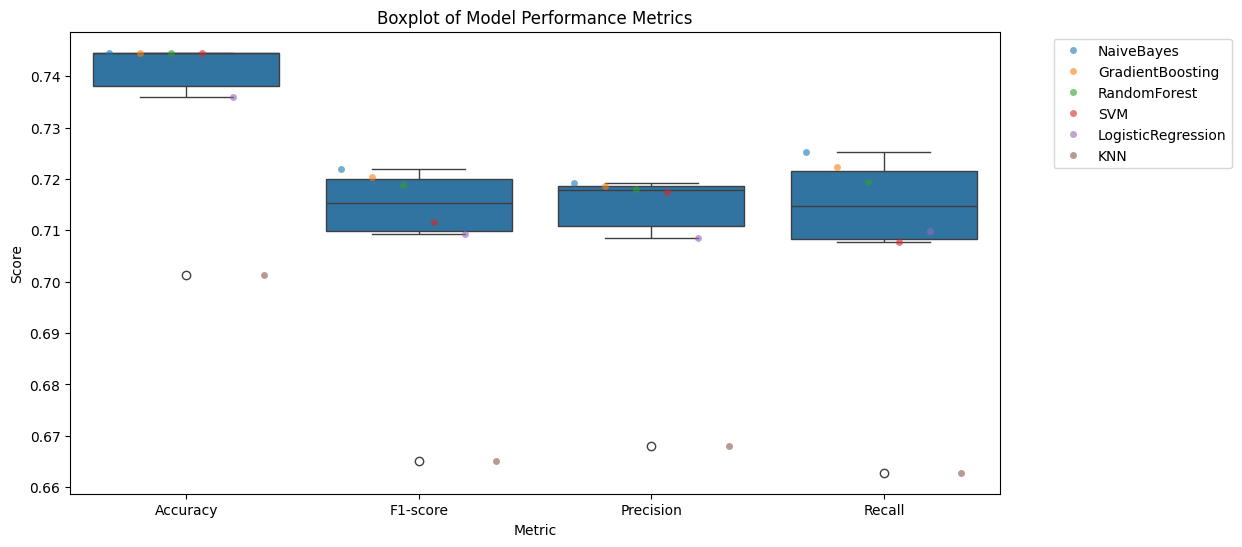

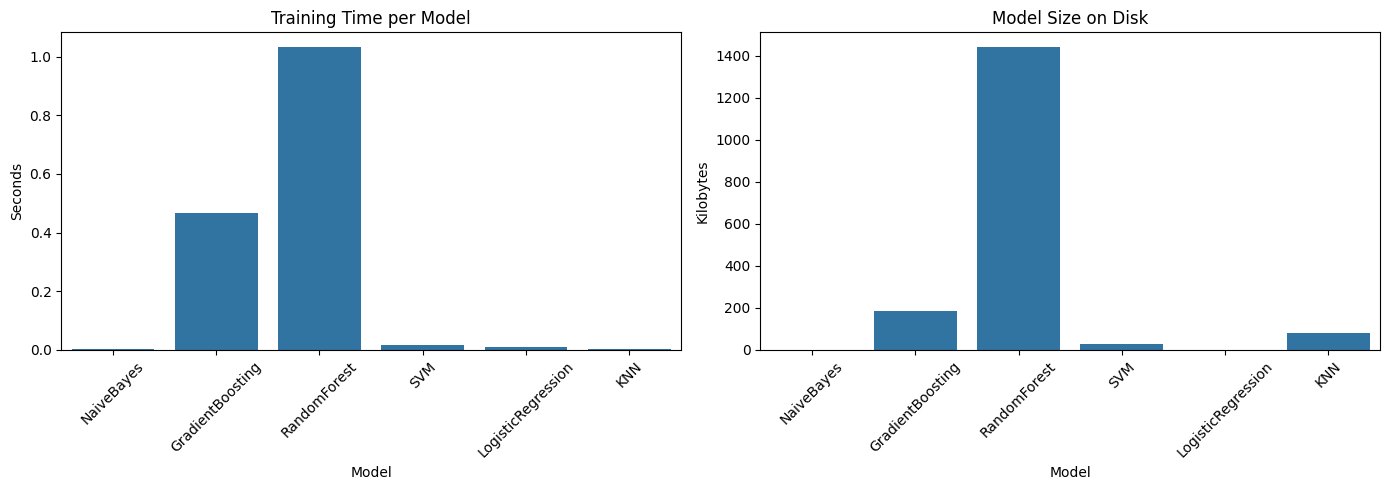


### Wine Quality ###
=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       213
           1       0.78      0.73      0.76       267

    accuracy                           0.74       480
   macro avg       0.73      0.74      0.73       480
weighted avg       0.74      0.74      0.74       480

=== SVM ===
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       213
           1       0.80      0.73      0.76       267

    accuracy                           0.75       480
   macro avg       0.75      0.75      0.75       480
weighted avg       0.75      0.75      0.75       480

=== RandomForest ===
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       213
           1       0.83      0.84      0.83       267

    accuracy                           0.81       480
   macro avg       0.81      0.81      0.81   

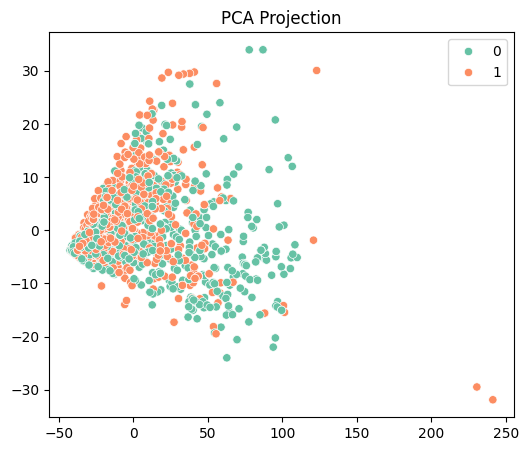

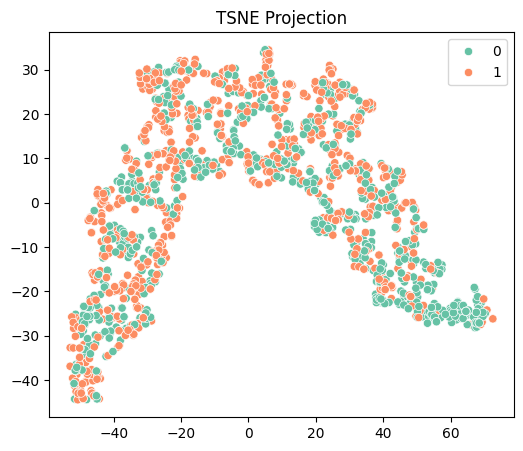

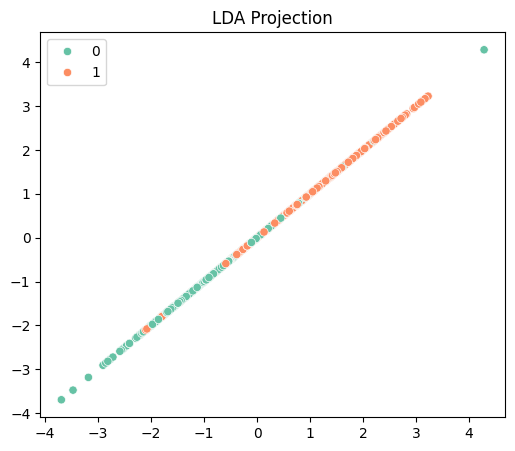

--- Bootstrap Evaluation (100 итераций, Random Forest) ---

--- Bootstrap Evaluation: 100 итераций ---
LogisticRegression        | Accuracy: 0.7494 ± 0.0188
SVM                       | Accuracy: 0.6314 ± 0.0211
RandomForest              | Accuracy: 0.8933 ± 0.0162
GradientBoosting          | Accuracy: 0.8360 ± 0.0177
NaiveBayes                | Accuracy: 0.7301 ± 0.0208
KNN                       | Accuracy: 0.6983 ± 0.0251

--- Bootstrap Evaluation: 250 итераций ---
LogisticRegression        | Accuracy: 0.7451 ± 0.0213
SVM                       | Accuracy: 0.6321 ± 0.0227
RandomForest              | Accuracy: 0.8938 ± 0.0156
GradientBoosting          | Accuracy: 0.8352 ± 0.0174
NaiveBayes                | Accuracy: 0.7254 ± 0.0229
KNN                       | Accuracy: 0.7034 ± 0.0234
--- Hyperparameter Tuning for SVM ---
Best Params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10.0}
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       21

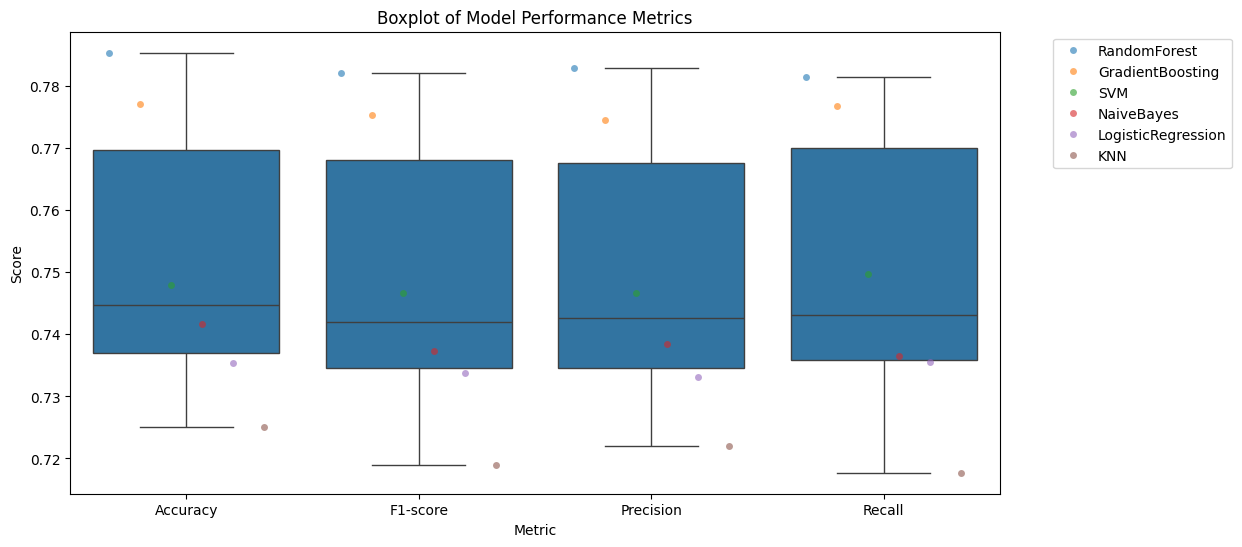

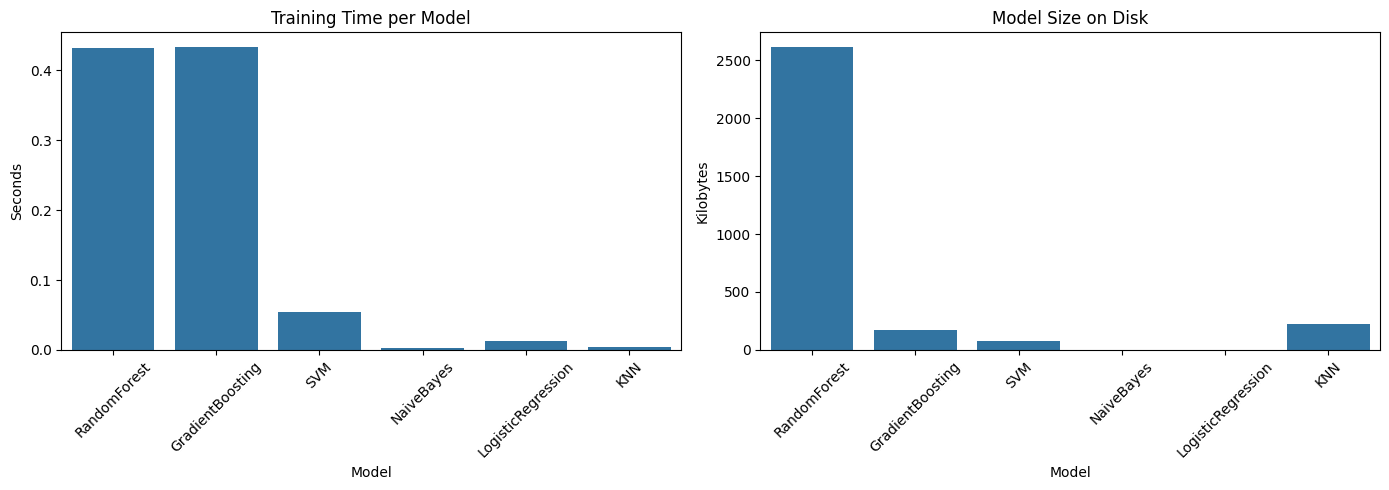

In [29]:
datasets = {
    "Pima Indians": ("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv",
                     ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome'], "Outcome"),
    
    "Wine Quality": ("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                     None, "quality")
}

import joblib
import os
from tempfile import TemporaryDirectory
from time import time

def evaluate_models(models_dict, X_train, X_test, y_train, y_test):
    results = []
    temp_dir = TemporaryDirectory()
    
    for name, model in models_dict.items():
        start = time()
        model.fit(X_train, y_train)
        fit_time = time() - start
        
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        acc = accuracy_score(y_test, y_pred)
        
        # Сохраняем модель во временный файл и измеряем размер
        model_path = os.path.join(temp_dir.name, f"{name}.pkl")
        joblib.dump(model, model_path)
        model_size = os.path.getsize(model_path) / 1024  # в КБ

        results.append({
            "Model": name,
            "Accuracy": round(acc, 4),
            "Precision": round(report['macro avg']['precision'], 4),
            "Recall": round(report['macro avg']['recall'], 4),
            "F1-score": round(report['macro avg']['f1-score'], 4),
            "Train Time (s)": round(fit_time, 4),
            "Model Size (KB)": round(model_size, 2)
        })

    temp_dir.cleanup()
    return pd.DataFrame(results).sort_values(by="F1-score", ascending=False)


def plot_model_metrics(results_df):
    melted = results_df.melt(id_vars='Model', 
                              value_vars=['Accuracy', 'F1-score', 'Precision', 'Recall'],
                              var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=melted, x='Metric', y='Score')
    sns.stripplot(data=melted, x='Metric', y='Score', hue='Model', dodge=True, alpha=0.6)
    plt.title("Boxplot of Model Performance Metrics")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def plot_time_and_size(results_df):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    sns.barplot(data=results_df, x='Model', y='Train Time (s)', ax=axs[0])
    axs[0].set_title("Training Time per Model")
    axs[0].set_ylabel("Seconds")
    axs[0].tick_params(axis='x', rotation=45)

    sns.barplot(data=results_df, x='Model', y='Model Size (KB)', ax=axs[1])
    axs[1].set_title("Model Size on Disk")
    axs[1].set_ylabel("Kilobytes")
    axs[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


for name, (path, columns, target) in datasets.items():
    print(f"\n### {name} ###")
    
    if columns:
        df = pd.read_csv(path, header=None, names=columns)
    else:
        df = pd.read_csv(path, sep=";")
    
    df.dropna(inplace=True)
    
    if df[target].nunique() > 5:
        df[target] = df[target].apply(lambda x: 1 if x >= df[target].median() else 0)
    
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = split_and_scale(X, y)
    
    models, reports = train_models(X_train, X_test, y_train, y_test)
    
    print("--- Dimension Reduction ---")
    reduce_and_plot(X.values, y.values, method="PCA")
    reduce_and_plot(X.values, y.values, method="TSNE")
    reduce_and_plot(X.values, y.values, method="LDA")
    
    print("--- Bootstrap Evaluation (100 итераций, Random Forest) ---")
    bootstrap_results = bootstrap_evaluation(models, X.values, y.values, iterations_list=[100, 250])
    
    print("--- Hyperparameter Tuning for SVM ---")
    param_dist = {
        "C": np.logspace(-3, 2, 6),
        "gamma": ['scale', 'auto'],
        "kernel": ['rbf', 'linear']
    }
    best_svm = random_search(SVC(), param_dist, X_train, y_train)
    y_pred = best_svm.predict(X_test)
    print(classification_report(y_test, y_pred))

    df_results = evaluate_models(models, X_train, X_test, y_train, y_test)
    print("\n=== Summary Table ===")
    print(df_results)

    plot_model_metrics(df_results)
    plot_time_and_size(df_results)


На датасете Pima Indians лучший результат показала модель NaiveBayes: лучшие метрики по Accuracy, Precision, Recall, F1-score, а также по времени обучения. По объему занимаемой памяти проигрывает только логистической регрессии. С бутстрепом результаты Accuracy выросли с 0.7446 до 0.8779 ± 0.0217 (на 250 итерациях).

Для датасета Wine Quality лучший результат у RandomForest, но по времени самым быстрым в обучении остается NaiveBayes. По памяти RandomForest занимает больше всего места. С бутстрепом результаты Accuracy выросли с 0.7854 до 0.8938 ± 0.0156 (на 250 итерациях).